# Basic Preprocessing and Analysis

In [1]:
#Importing the needed libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandasql import sqldf

sns.set_theme()
# For the image quality of the graphic. 
sns.set(rc={"figure.dpi":300})
# For the size of the graphics
sns.set(rc = {"figure.figsize":(15,5)})

import warnings

In [2]:
# Setting the path so that it can be used as a variable
path = '/Users/dannyrambhatla/Downloads/Sonar_files/'

In [3]:
# Reading in the files
opps = pd.read_excel(f'{path}Opportunity_Report_modified.xlsx',parse_dates=['Created Date','Close Date','True Pipe Date'])
leads = pd.read_csv(f'{path}Leads_Report.csv', parse_dates=['Create Date'])
reps = pd.read_csv(f'{path}Rep_Roster.csv', parse_dates=['Start Date','Ramped Date'])

In [4]:
# Combining Opps data with Leads
df = pd.merge(opps, leads, on='Lead Record Id', how='left')
df = df.drop('Description', axis=1)
df["Converted to Opp"] = df["Converted to Opp"].fillna(0)

In [5]:
# Assessing the column names and data types
df.dtypes

Opportunity ID                                 object
Stage                                          object
Fiscal Period                                  object
Created Date                           datetime64[ns]
Close Date                             datetime64[ns]
Lead Record Id                                 object
Beneficial Owner                               object
Beneficial Owner Dept                          object
Amount True Pipe NC (converted)               float64
Amount True Pipe UP (converted)               float64
True Pipe Date                         datetime64[ns]
AmountNewBizNewCustomer (converted)           float64
AmountNewBizUpsell (converted)                float64
NC_ForecastedRevenue                          float64
NC_ClosedRevenue                              float64
First Name                                     object
Lead Source                                    object
Converted to Opp                              float64
Create Date                 

In [6]:
# Checking sample rows to get a basic understanding
df.head(5)

,Opportunity ID,Stage,Fiscal Period,Created Date,Close Date,Lead Record Id,Beneficial Owner,Beneficial Owner Dept,Amount True Pipe NC (converted),Amount True Pipe UP (converted),True Pipe Date,AmountNewBizNewCustomer (converted),AmountNewBizUpsell (converted),NC_ForecastedRevenue,NC_ClosedRevenue,First Name,Lead Source,Converted to Opp,Create Date
0,0067U000007jv3N,Closed Won,Q1-2023,2023-01-31,2023-02-22,NaN,Kimberly Bracher,Commercial Expansion,0.0,200000.0,2023-02-08,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaT
1,0067U0000067e4q,Closed Lost,Q4-2022,2022-11-28,2022-12-27,00Q7U000008rtZc,Berkay Bektas,Commercial Acquisition,0.0,0.0,NaT,34782.6,0.0,0.0,34782.6,Cardo,SQ Eval form,1.0,2022-11-28
2,0067U000002lVQZ,Closed Lost,Q3-2022,2022-06-22,2022-08-22,NaN,John-Philippe Lalive d'Epinay,Commercial Expansion,0.0,0.0,NaT,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaT
3,0062p00001FTBdK,Closed Lost,Q4-2021,2021-09-27,2021-11-18,NaN,Melanie Fritzsche,Commercial Expansion,0.0,0.0,NaT,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaT
4,0062p00000z485t,Closed Lost,Q2-2021,2019-06-13,2021-04-15,NaN,Bartosz Zieterski,Enterprise Acquisition,182500.0,0.0,2021-03-05,182500.0,0.0,182500.0,182500.0,NaN,NaN,0.0,NaT


In [7]:
# Convert Revenue column to integer
# This cell has only been included to show that columns can be modified using Python too. I modified revenue columns to be
# numbers in the sheet provided for time purposes.

#df['NC_ClosedRevenue'] = df['NC_ClosedRevenue'].astype(str).str.replace('[$,]', '').replace('$ -   ', '0').replace(' -   ','0').astype('float')
#df['NC_ForecastedRevenue'] = df['NC_ForecastedRevenue'].astype(str).str.replace('[$-]', '').astype('float')
#warnings.filterwarnings('ignore')

# Top sources by New customer revenue

## Query

In [104]:
# Top 5 sources by NC Revenue

query = """
           WITH lead_to_NCrevenue as
           (
           select
           "Lead Source" as "Lead_Source",
           ROUND(CAST(sum("NC_ClosedRevenue") AS INTEGER)/1000000.0,2) as "NCRevenue(in millions)"
           --ROW_NUMBER() OVER (PARTITION BY strftime('%Y',"Close Date") order by CAST(sum("NC_ClosedRevenue") AS INTEGER) desc) as "Rank"
           from df
           where "Stage" = "Closed Won" and "Lead Record Id" is not null
           and "Lead Source" is not null
           group by "Lead Source" 
           order by 2 desc
           LIMIT 5
           )
           
           select * from lead_to_NCrevenue 
           
           
        """ 
top_sources_by_NCRevenue = sqldf(query)
top_sources_by_NCRevenue

,Lead_Source,NCRevenue(in millions)
0,SQ Eval form,117.11
1,Information Form,107.10
2,Partner/Reseller referred,37.97
3,SS Eval form,36.96
4,SonarCloud form,32.38


## Visual Plot

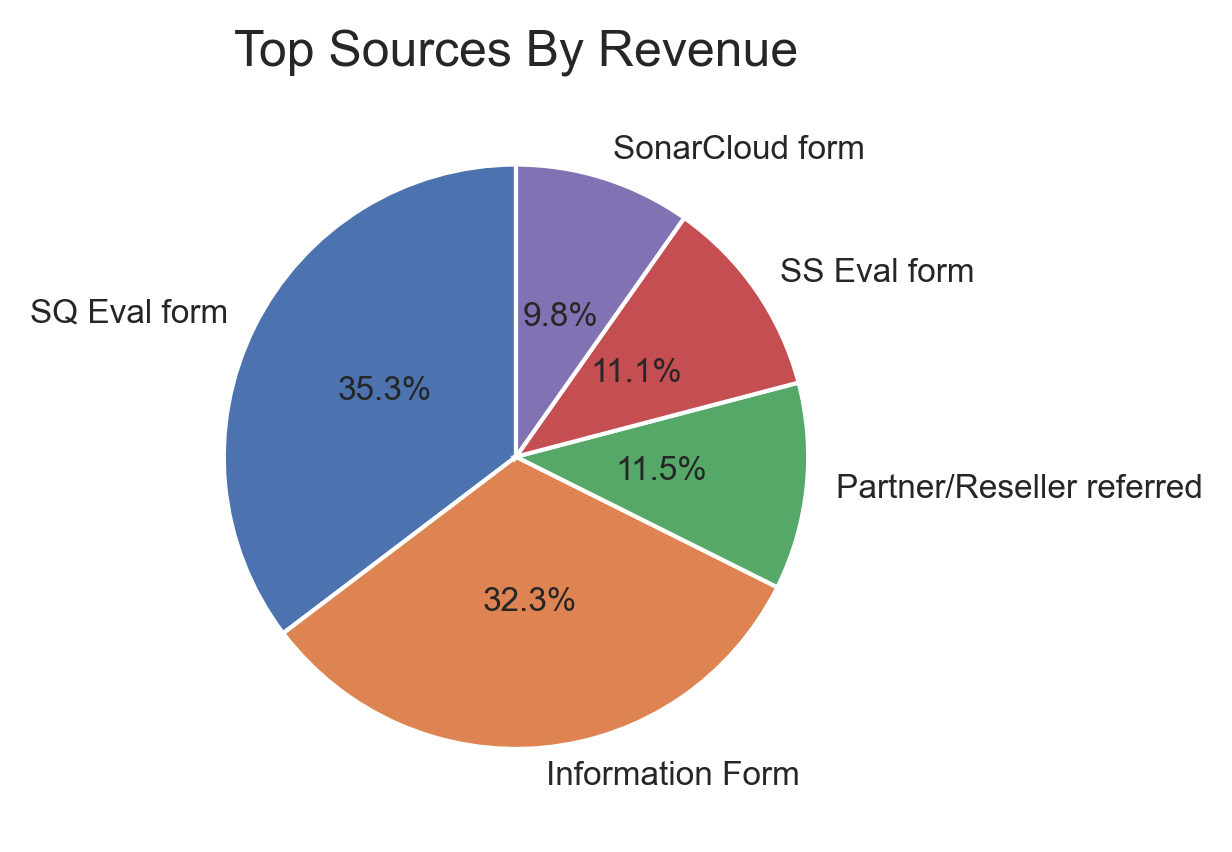

In [241]:
#Generate plot
plt.figure(figsize=(10,3))
plt.pie(data=top_sources_by_NCRevenue,x='NCRevenue(in millions)',
labels='Lead_Source',pctdistance=0.5,labeldistance=1.1,startangle=90,autopct='%1.1f%%',wedgeprops={'edgecolor': 'white', 'linewidth': 1},
       textprops={'fontsize': 8},radius=1)
plt.title('Top Sources By Revenue', fontsize=12)
plt.tight_layout()
plt.show()

## Observation

Listed are the top 5 sources for revenue generated by new inbound customers. This has been exclusively created to show the correlation with [Sales Opportunity Conversion Rate By Source](#section-title) to be able to show the difference in behavior of these sources when it comes to conversion.  


# Sales Opportunity Conversion Rate By Source

## Query

In [10]:
# Sales Qualified Lead(SQL) Conversion Rate since 2021 ( By Source - Upsell excluded)

''''
Note: Total leads was modified to consider SQL'ed and forward.
If website metrics were provided, an overall lead conversion metric could be established 
which would include conversions from visitor to MQL as well.
'''

query = """
           WITH lead_to_sale as
           (
           select "lead Source" as "Lead_Source", 
           --strftime('%Y',"True Pipe Date") as "Year",
           count(case when "Stage" = "Closed Won" then "Lead Record Id" end) as "Converted_Leads",
           count(case when "True Pipe Date" is not null then "Lead Record Id" end) as "Total_Leads"
           from df
           where "Lead Record Id" is not null --and "True Pipe Date" is not null
           and strftime('%Y',"True Pipe Date") > '2020'
           group by --"Year",
           "Lead Source" 
           --order by "Year"
           ),
           
           conv_rate as
           (
           select *, ("Converted_Leads" * 100 / "Total_leads") as conv_pct
           from lead_to_sale
           )
           
           
           select --"Year",
           "Lead_Source","Total_Leads","Converted_Leads","conv_pct"
           from conv_rate
           order by "conv_pct" desc
           
        """ 

lead_to_sale_conversion = sqldf(query)
lead_to_sale_conversion


,Lead_Source,Total_Leads,Converted_Leads,conv_pct
0,Renewal,9,8,88
1,Personal Contact,155,99,63
2,Email to contact@,207,115,55
3,Partner/Reseller referred,839,457,54
4,SonarCloud form,654,357,54
5,Reactivate prospect,8,4,50
6,SS Eval form,1586,800,50
7,Information Form,1663,740,44
8,None,815,305,37
9,Events,3,1,33


## Visual Plot

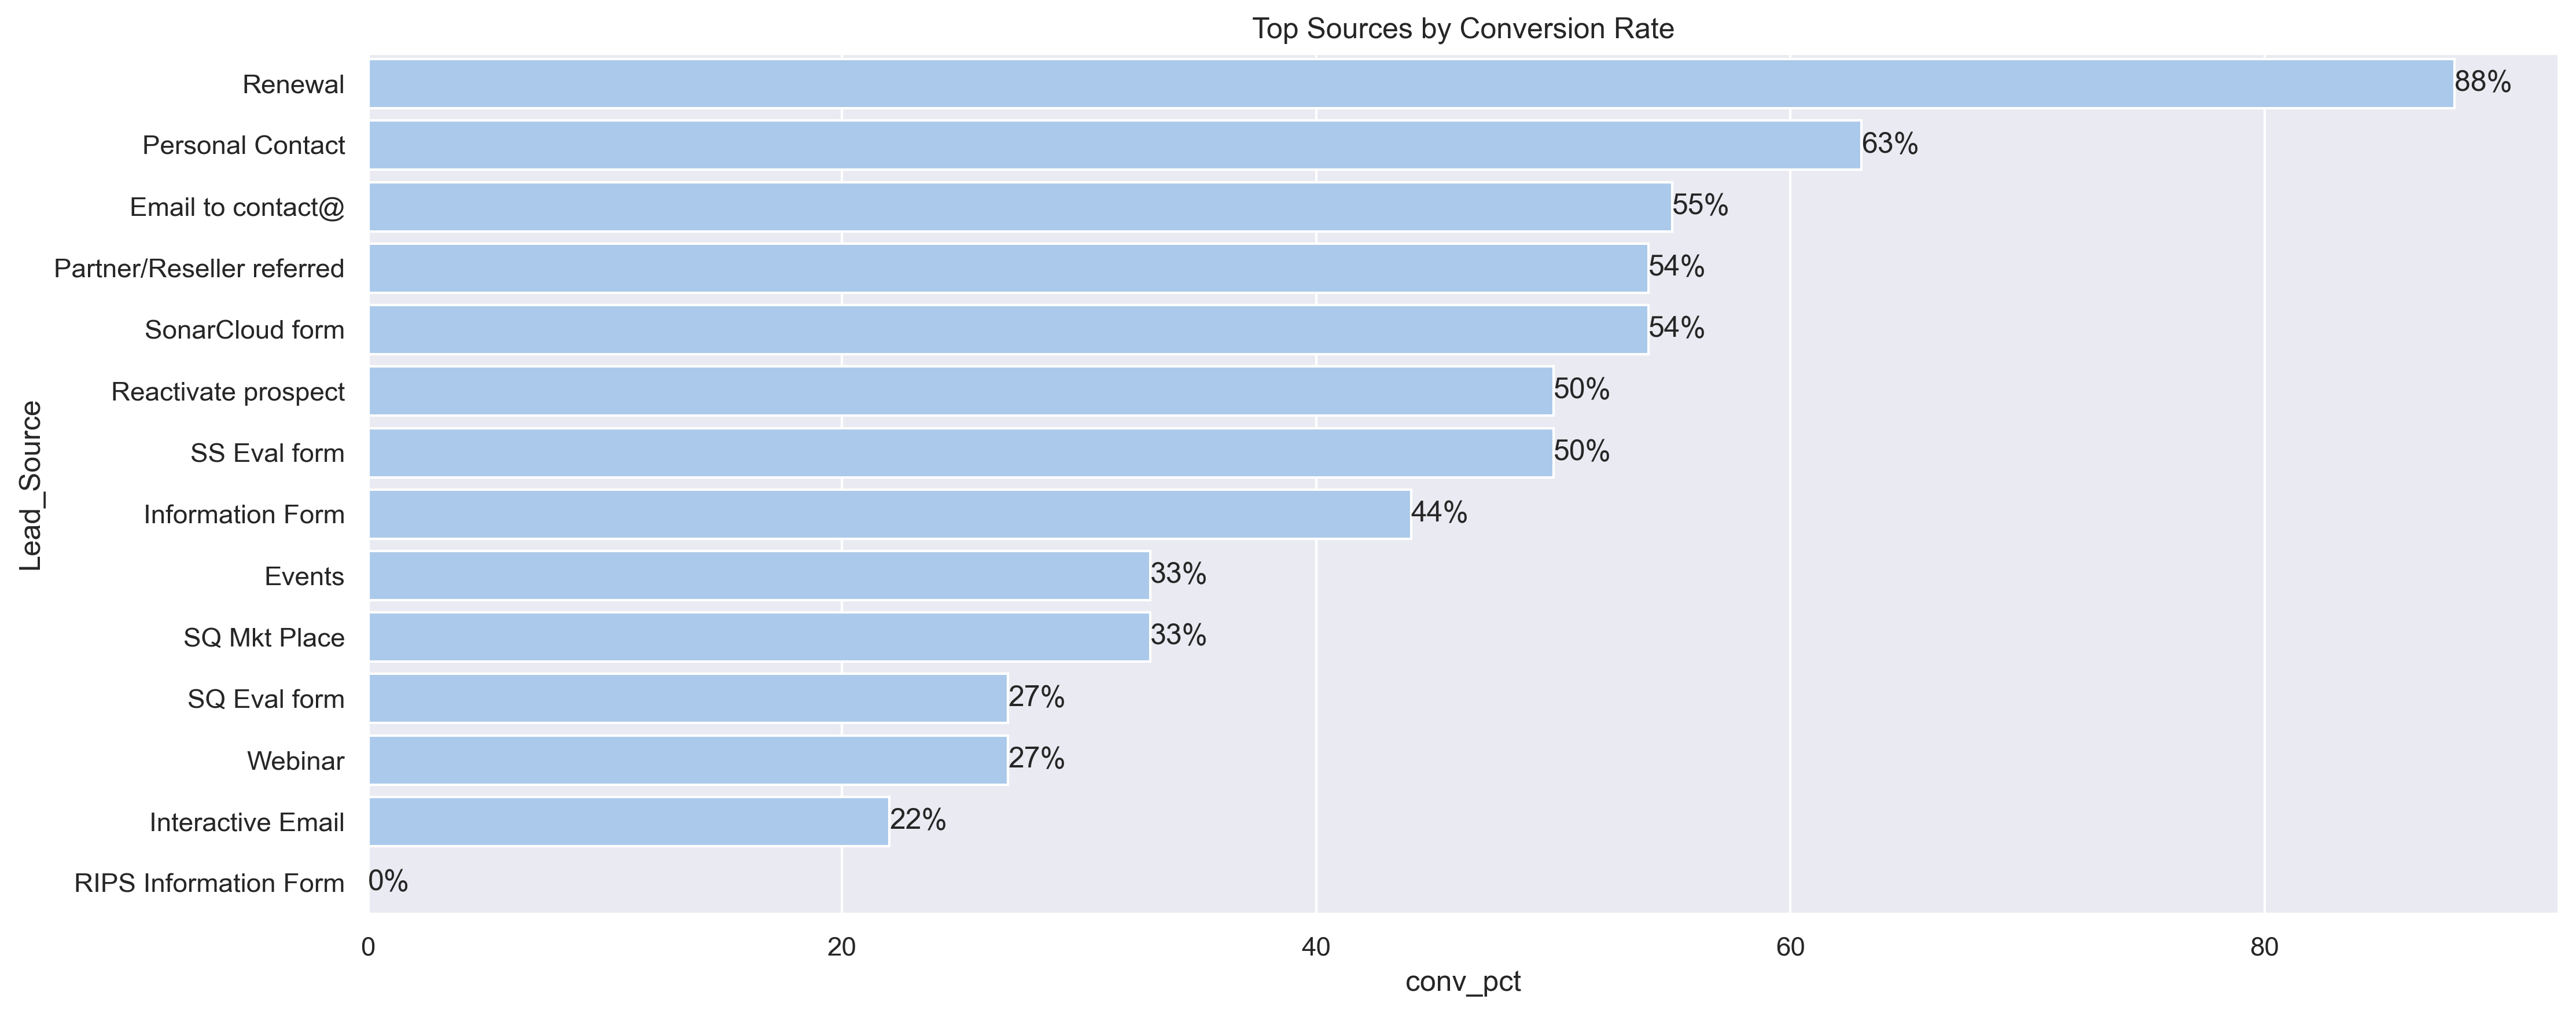

In [11]:
#Generating the plot
sns.set(rc = {"figure.figsize":(15,6)})
sns.set_color_codes("pastel")
ax = sns.barplot(x='conv_pct',y='Lead_Source',data=lead_to_sale_conversion, orient='h',color='b')

for bars in ax.containers:
        ax.bar_label(bars, fmt='%i%%')
plt.title('Top Sources by Conversion Rate')
plt.tight_layout()

## Observation: 

At initial glance, we might see that SonarQube Eval form,Information form and Referrals by Partners or Resellers seem to be the top 3 sources for incoming leads in terms of "volume" and "revenue" but from a conversion standpoint, rank below than expected. If we choose to ignore Renewals having the highest conversion rate, Personal contact and Email to contact@ seem to be higher in "effectiveness". 

Few reasons for key sources having low conversion rates could be:
> 1. Low quality leads, which in turn, could be indicating a faulty lead scoring model.
2. Analysis of Closed Lost could reveal lot of insights as well. 
3. Deeper analysis into conversion through each stage of the pipeline prior to Closed Lost has the highest potential to identify the root cause.
 

In [12]:
# Generating the YoY plot( if needed, after modifying the query)
'''
sns.set(rc = {"figure.figsize":(15,6)})
sns.set_color_codes("pastel")
ax = sns.barplot(x='Lead_Source',y='conv_pct',hue="Year",data=lead_to_sale_conversion,color='b')

for bars in ax.containers:
        ax.bar_label(bars, fmt='%i')
plt.title('Top Sources by Conversion Rate')
plt.xticks(rotation=30)
'''

'\nsns.set(rc = {"figure.figsize":(15,6)})\nsns.set_color_codes("pastel")\nax = sns.barplot(x=\'Lead_Source\',y=\'conv_pct\',hue="Year",data=lead_to_sale_conversion,color=\'b\')\n\nfor bars in ax.containers:\n        ax.bar_label(bars, fmt=\'%i\')\nplt.title(\'Top Sources by Conversion Rate\')\nplt.xticks(rotation=30)\n'

# Closed Won Opportunities Growth Rate

## Query

In [138]:
# Closed Won Opportunity Conversion Growth Rate QoQ

query = """
           WITH lead_to_opp as
           (
           select "Fiscal Period" as "Fiscal_Period",CASE WHEN "Fiscal Period" like '%-2021' then 1
                       WHEN "Fiscal Period" like '%-2022' then 2 else 3 end
                       as "Fiscal_Period_Order",
           count(distinct "Opportunity Id") as "Conversions"
           from df
           where "Stage" = "Closed Won" and "Lead Record Id" is not null
           group by "Fiscal Period",CASE WHEN "Fiscal Period" like '%-2021' then 1
                       WHEN "Fiscal Period" like '%-2022' then 2 else 3 end
           )
           
           select "Fiscal_Period","Conversions"
           from lead_to_opp 
           order by "Fiscal_Period_Order"
           
           
        """ 
conversion_growth = sqldf(query)
conversion_growth


,Fiscal_Period,Conversions
0,Q1-2021,627
1,Q2-2021,635
2,Q3-2021,673
3,Q4-2021,698
4,Q1-2022,766
5,Q2-2022,713
6,Q3-2022,629
7,Q4-2022,591
8,Q1-2023,369


## Visual Plot

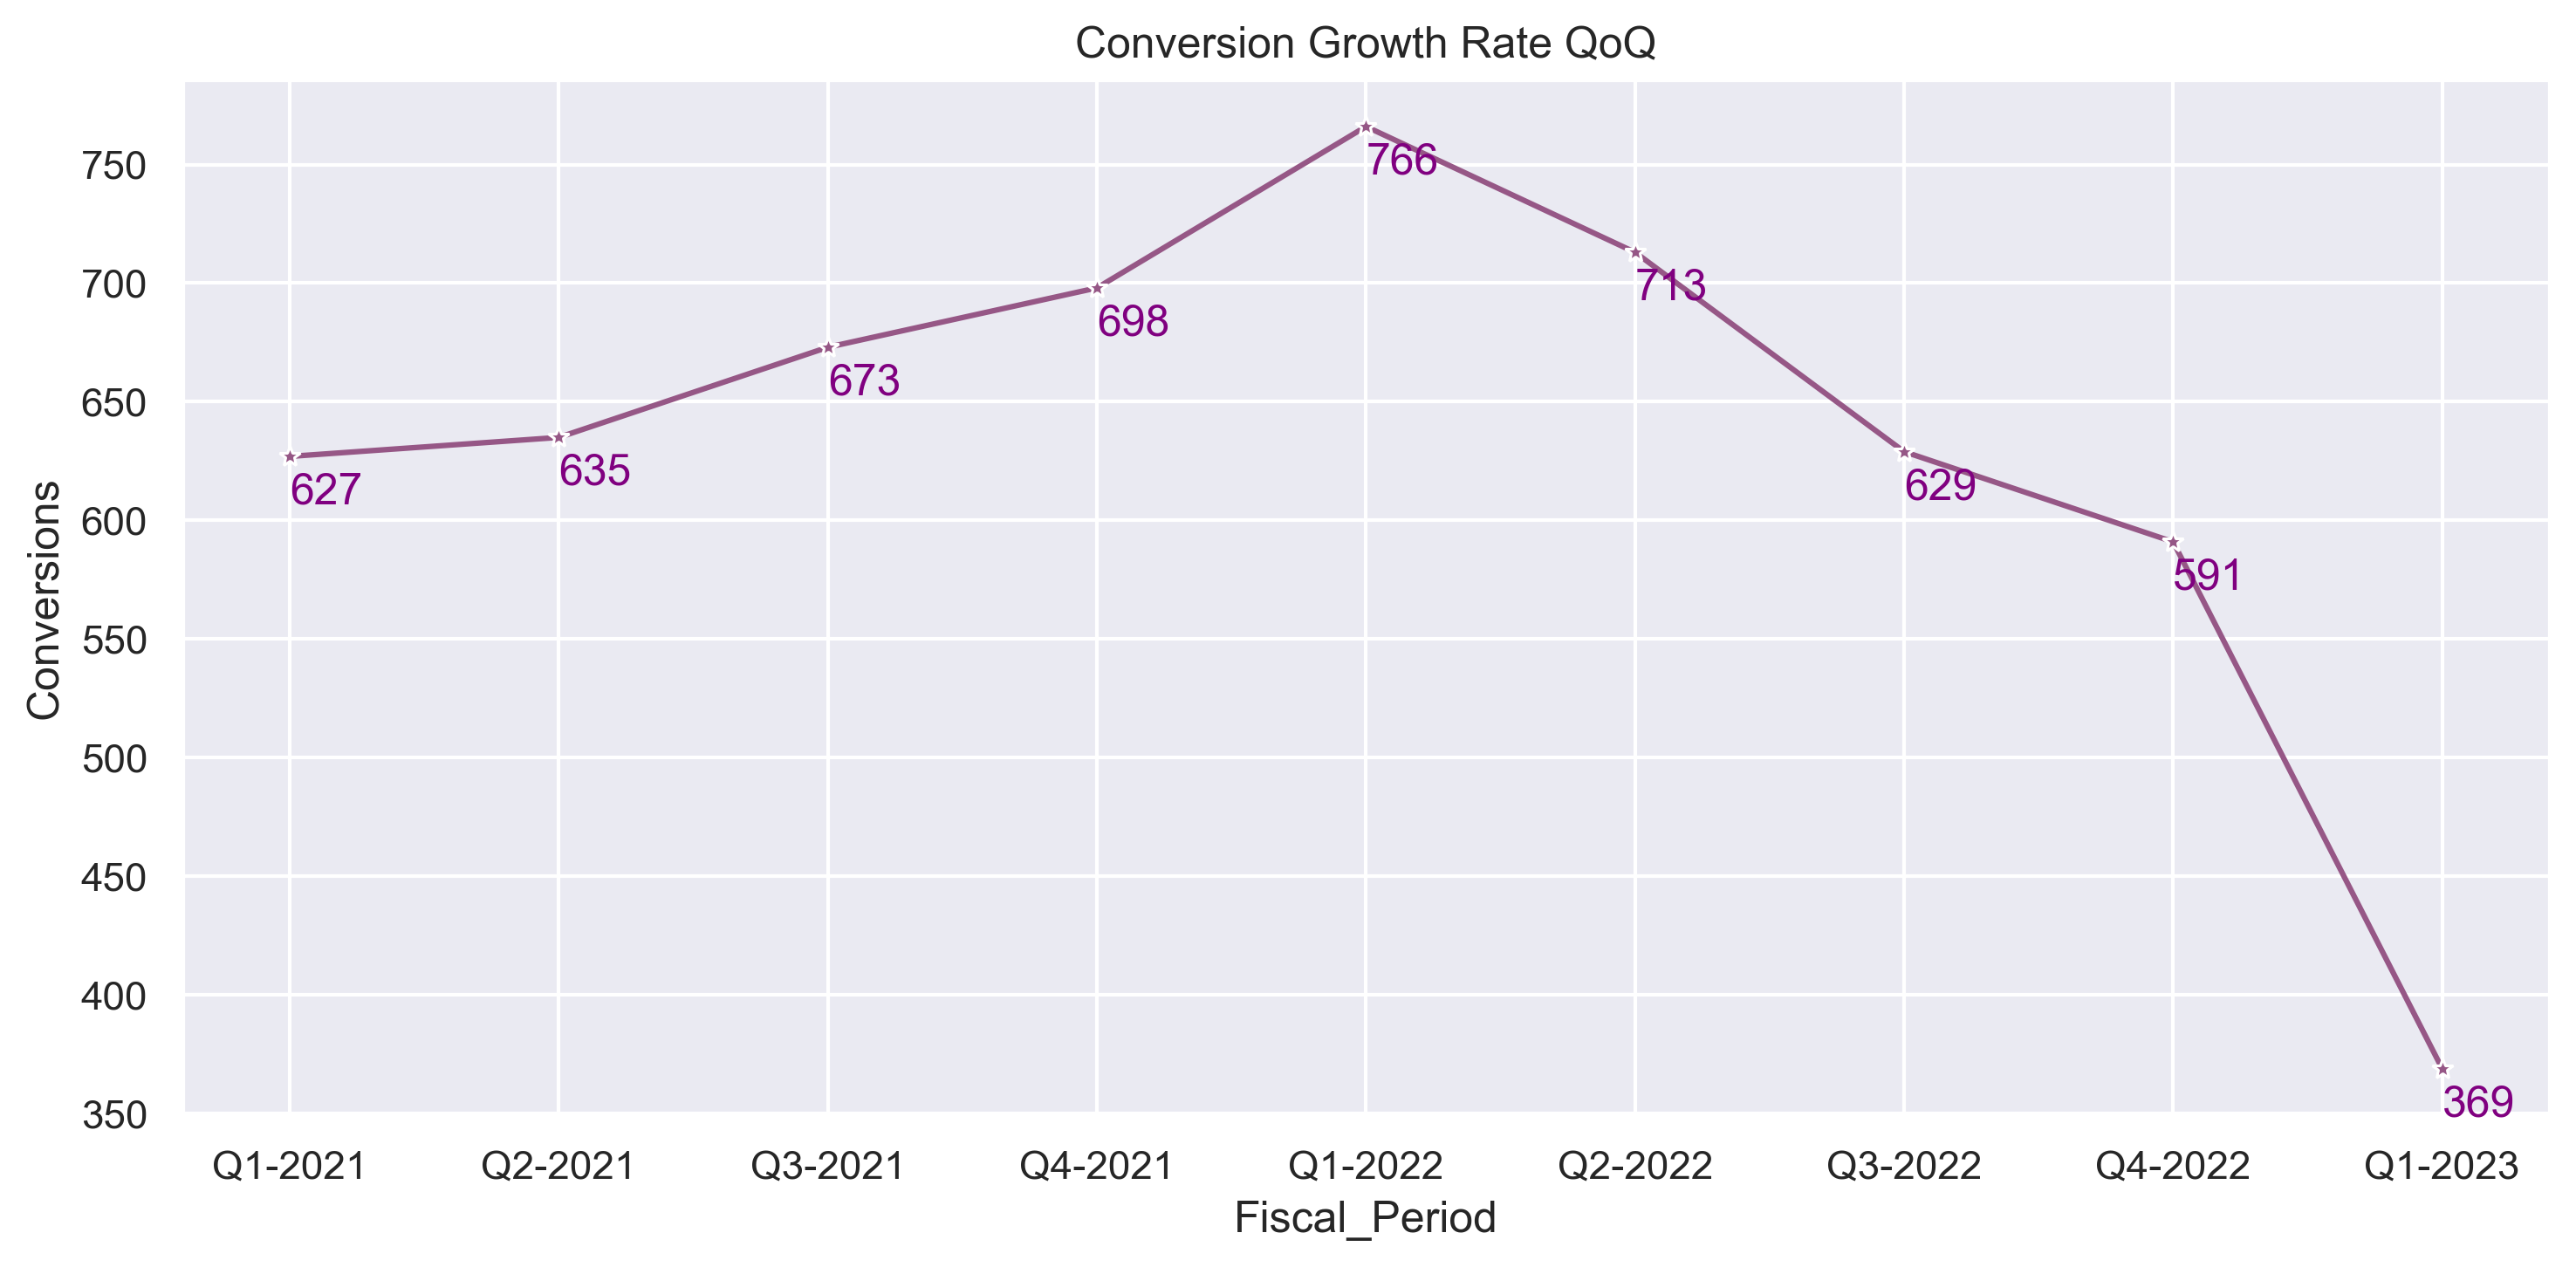

In [139]:
#Generate line plot
sns.set(rc={"figure.figsize":(10,5)})
ax = sns.lineplot(x='Fiscal_Period',y='Conversions',data=conversion_growth,marker='*',color='#965786')
ax.set(title='Conversion Growth Rate QoQ')
plt.tight_layout()

# label points on the plot'
for x, y in zip(conversion_growth['Fiscal_Period'], conversion_growth['Conversions']):
 # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
 plt.text(x = x, # x-coordinate position of data label
 y = y-20, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(y), # data label, formatted to ignore decimals
 color = 'purple') # set colour of line

## Observation:

Above is a promising high level view of the Sales teams effectiveness towards the revenue growth of Sonar. 2022 saw a ~22 % growth YoY and first quarter of 2023, even with a couple of weeks still remaining, looks on track to close strong.   

# Top 5 teams by Revenue Generated YoY ( NC Revenue only)

## Query

In [225]:
# Top 5 teams by Revenue YoY
# I have removed CW Opportunities for which there is no owner
query = """
           WITH top_5_teams_by_revenue as
           (
           select strftime('%Y',"Close Date") as "Year",
           CASE WHEN "Beneficial Owner Dept" is null then "No Team" else "Beneficial Owner Dept" end as "Team",
           ROUND(CAST(sum("NC_ClosedRevenue") AS INTEGER)/1000000.0,2) as "NCRevenue(in millions)",
           ROW_NUMBER() OVER (PARTITION BY strftime('%Y',"Close Date") order by CAST(sum("NC_ClosedRevenue") AS INTEGER) desc) as "Rank"
           from df
           where "Stage" = "Closed Won" and "Beneficial Owner Dept" is not null
           and "Lead Record Id" is not null
           group by strftime('%Y',"Close Date"),"Beneficial Owner Dept" order by 1,3 desc 
           )
           
           select "Year","Team","NCRevenue(in millions)" from top_5_teams_by_revenue where "Rank" <= 5
           
        """ 
top_teams_by_NCRevenue = sqldf(query)
top_teams_by_NCRevenue

,Year,Team,NCRevenue(in millions)
0,2021,Enterprise Acquisition,159.08
1,2021,Commercial Acquisition,20.59
2,2021,Global Team,12.15
3,2021,Global Account Manager,10.90
4,2021,Commercial Expansion,4.86
5,2022,Enterprise Acquisition,147.53
6,2022,Commercial Acquisition,25.36
7,2022,Global Account Manager,18.37
8,2022,Global Team,12.73
9,2022,Commercial Expansion,1.79


## Visual Plot

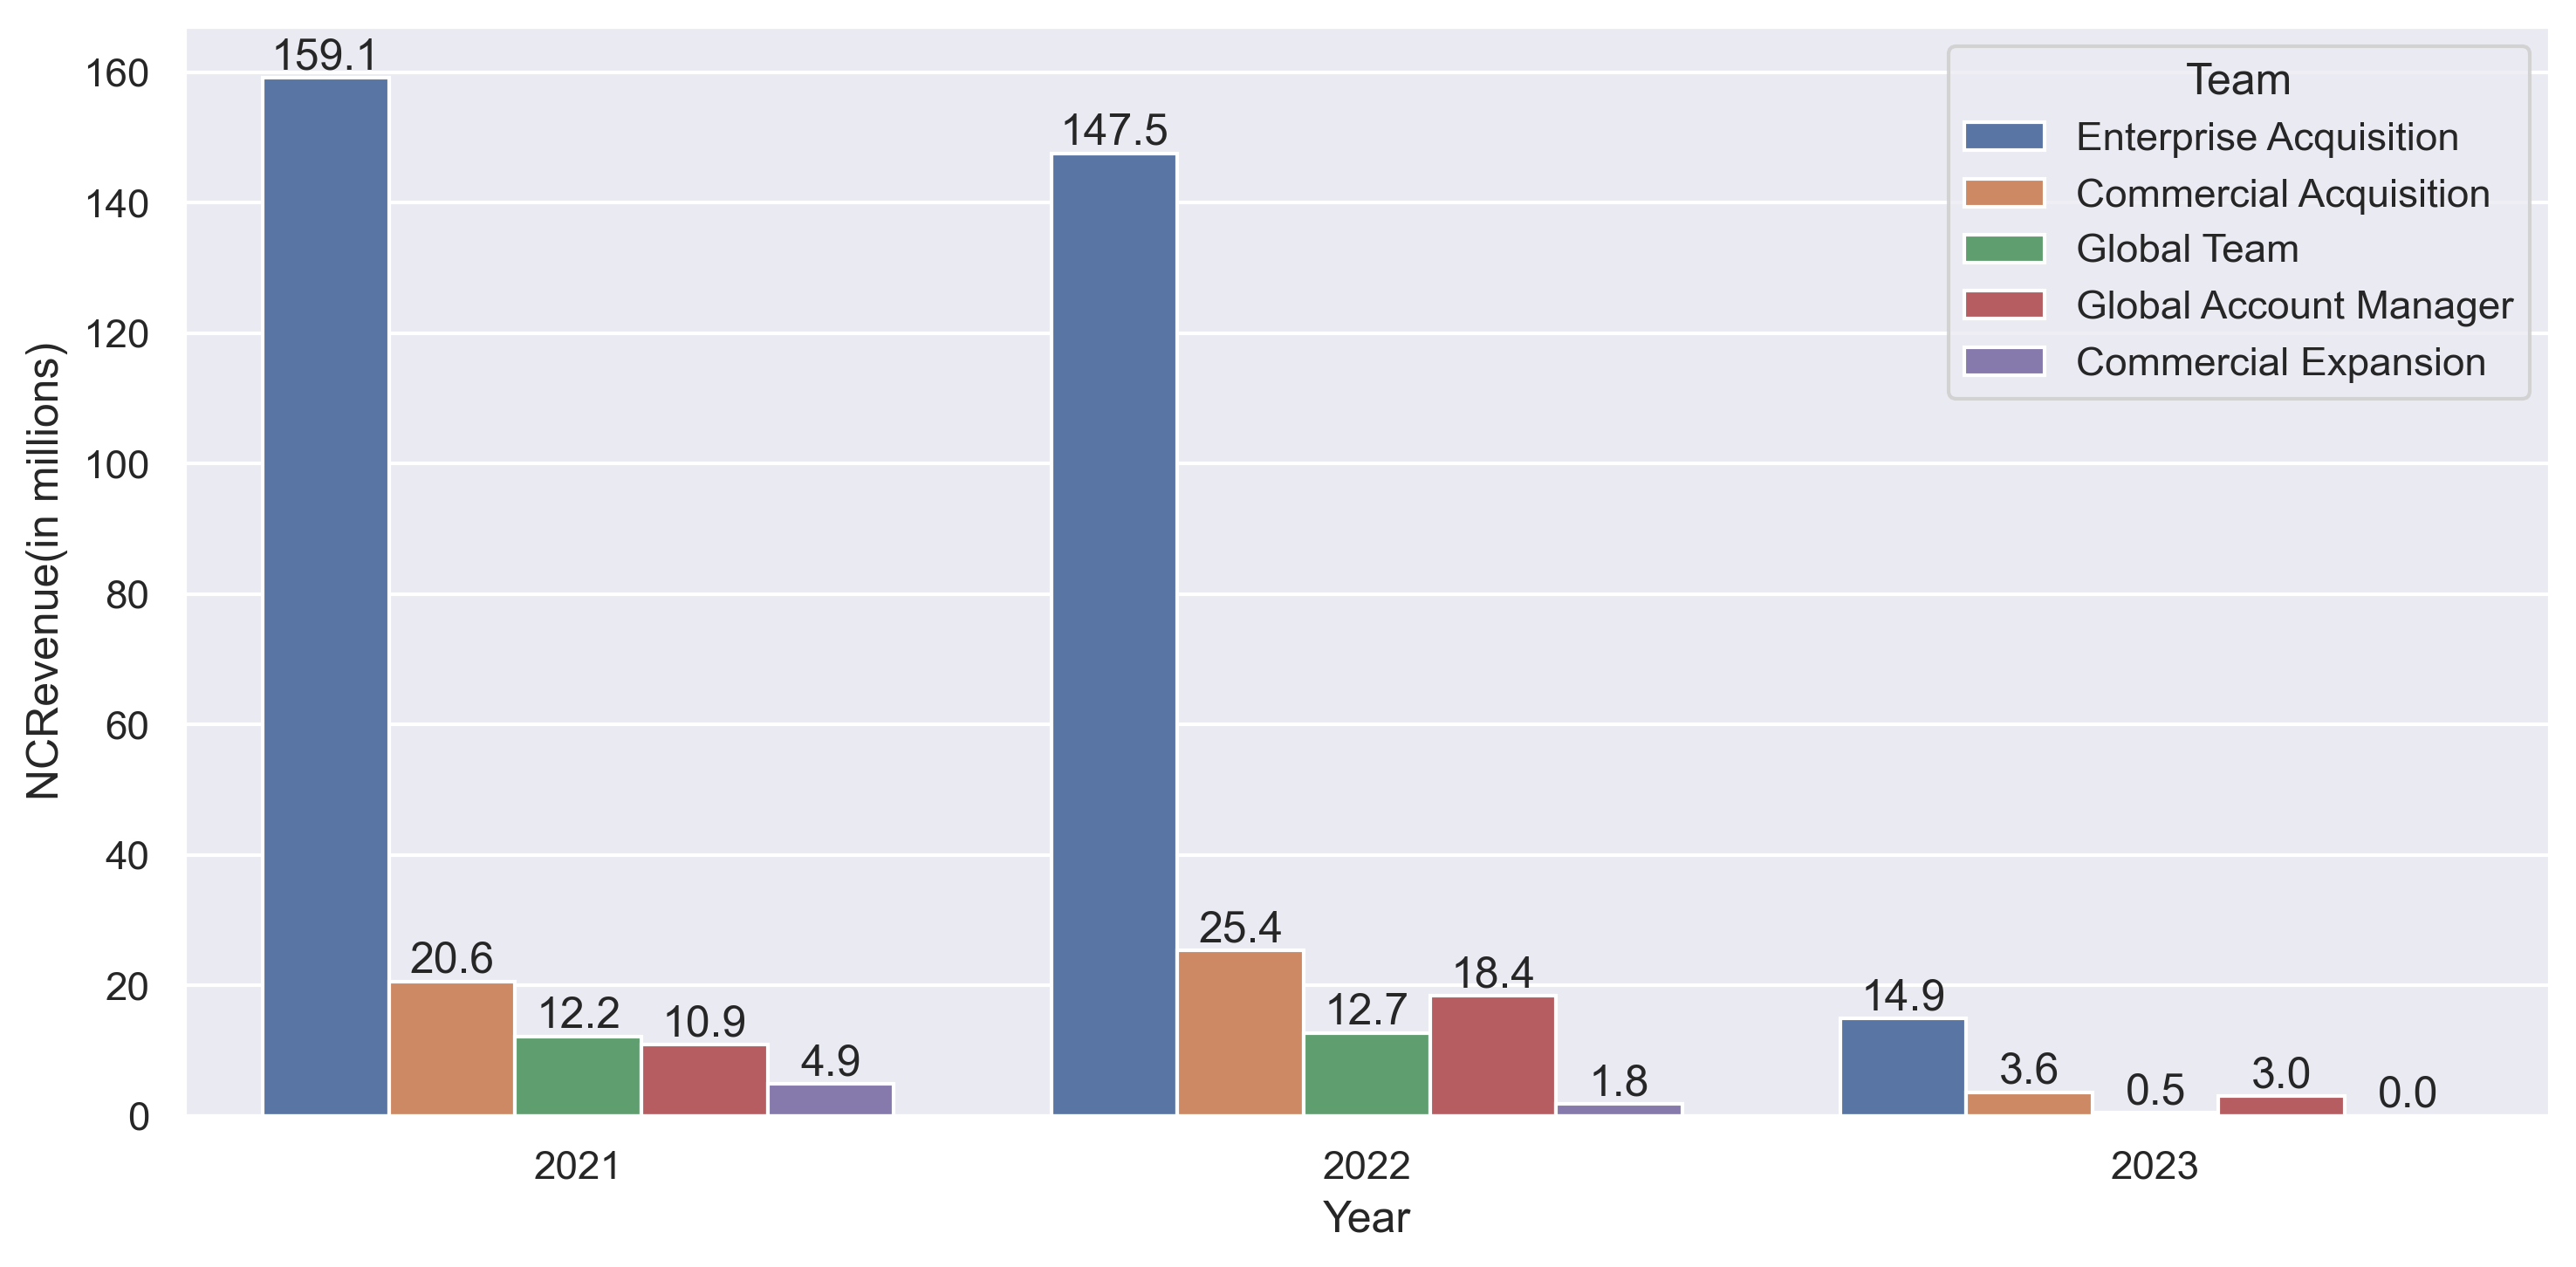

In [238]:
#Generate plot
ax = sns.barplot(x='Year',y='NCRevenue(in millions)',hue = "Team",data=top_teams_by_NCRevenue)

#ax.bar_label(ax.containers[0])
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.1f')
plt.tight_layout()

## Observation

Above observation is just a quick glance to check the most revenue generating teams but is in correlation with 
[Top Teams by Win Rate YoY](#section-title) to identify any differences between revenue vs conversion effectiveness and dive deeper into why that might be happening.

# Top Teams by Win Rate YoY

## Query 

In [230]:
# I chose 8 teams solely for the purpose of showing behavior of "Enterprise Acquisition" team being the top team in 
# terms of revenue but lagging in terms of conversion.

query = """
           WITH opp_type_by_team as
           (
           select strftime('%Y',"Close Date") as "Year",
           CASE WHEN "Beneficial Owner Dept" is null then "No Team" else "Beneficial Owner Dept" end as "Team",
           count("Opportunity Id") as "Total_Opportunities",
           count(case when "Stage" = "Closed Won" then "Opportunity Id" end) as "Closed_Won",
           count(case when "Stage" = "Closed Lost" then "Opportunity Id" end) as "Closed_Lost"
           from df
           where "Lead Record Id" is not null
           group by strftime('%Y',"Close Date"),
           CASE WHEN "Beneficial Owner Dept" is null then "No Team" else "Beneficial Owner Dept" end
           ),
           
           win_rate as
           (
           select *,(("Closed_Won" * 100) / ("Closed_Lost" + "Closed_Won")) as "Win_Rate(%)"
           from opp_type_by_team
           ),
           
           top_8_teams_by_win_rate as
           (
           select *, ROW_NUMBER() OVER (PARTITION by "Year" ORDER BY "Win_Rate" desc) as "Rank"
           from win_rate
           )
           
           select "Year","Team","Total_Opportunities","Closed_Won","Closed_Lost","Win_Rate(%)"
           from top_8_teams_by_win_rate
           where "Rank" <=8
           
        """ 

top_team_by_winrate = sqldf(query)
top_team_by_winrate

,Year,Team,Total_Opportunities,Closed_Won,Closed_Lost,Win_Rate(%)
0,2021,Commercial Acquisition,6184,1272,4912,20.0
1,2021,Commercial Expansion,867,195,672,22.0
2,2021,Country Manager,1874,10,1864,0.0
3,2021,Enterprise Account Managers,1,0,1,0.0
4,2021,Enterprise Acquisition,6593,956,5637,14.0
5,2021,Global Account Manager,693,129,564,18.0
6,2021,Global Team,536,67,469,12.0
7,2021,No Team,17,4,13,23.0
8,2022,Commercial Acquisition,8363,1693,6670,20.0
9,2022,Commercial Expansion,278,98,180,35.0


## Visual Plot

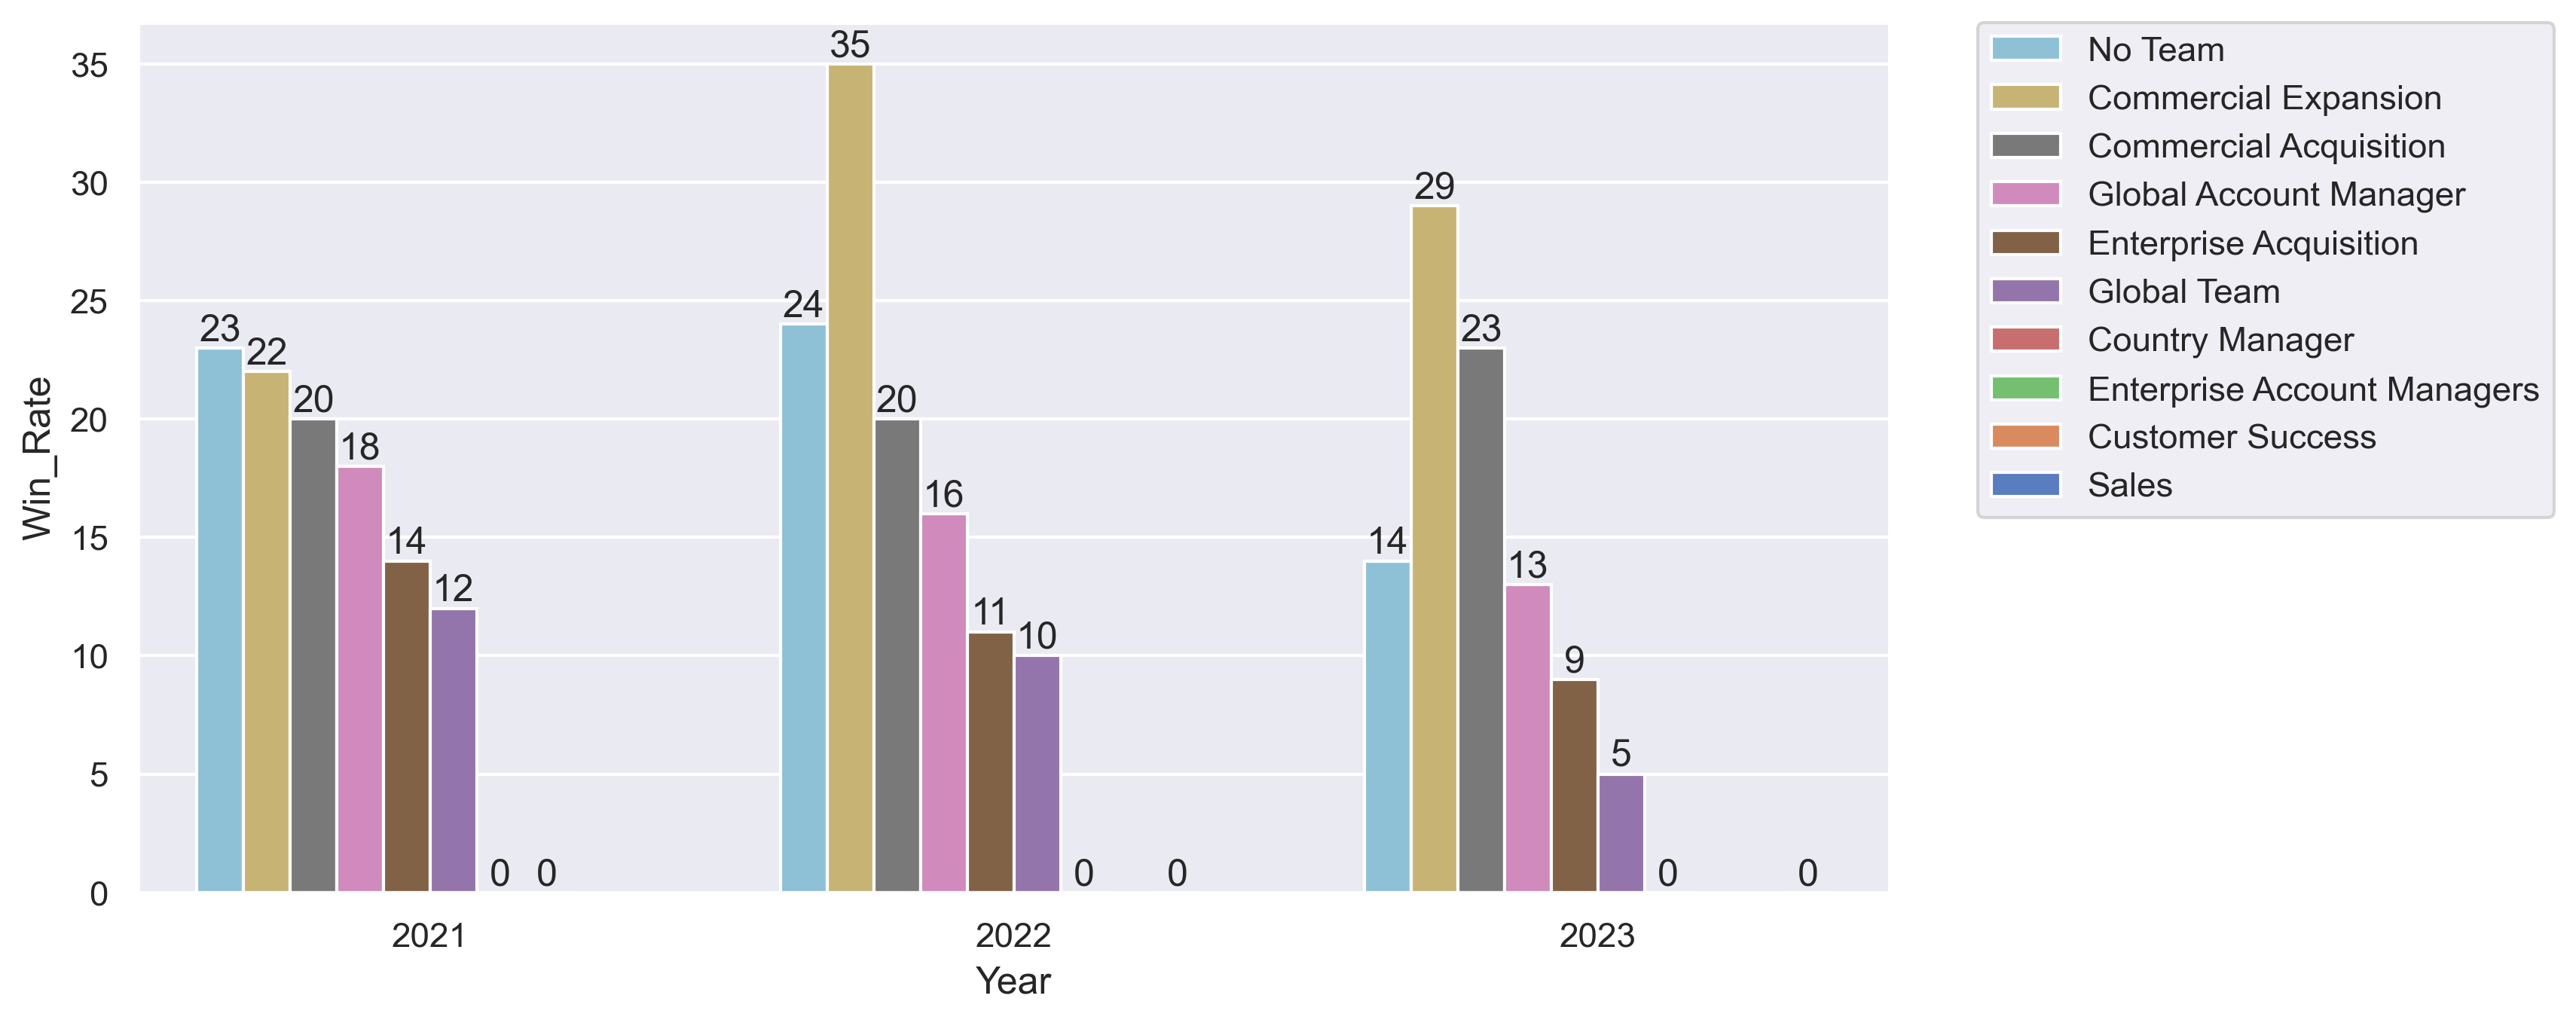

In [142]:
# Generate plot
palette = sns.color_palette("muted")
palette.reverse()
ax = sns.barplot(x='Year',y='Win_Rate',hue="Team",data=top_team_by_winrate, palette=palette)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%i')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


## Observation

Top Revenue generating teams might not be directly proportional to they being the top "effective" teams
as well. Win Rate here helps me identify the "potentially" good teams and piques my interest as to what strategies those teams might be using to close such a high percentage of deals from their pool. This can be applied to individual sales reps as well. 

So improvement or optimization need not flow top down from the "big" teams.

I have not raised "No team" being an issue in the mix since this is dummy data but just in case this is an extract from Salesforce, then it could be concerning. There are lot of Closed deals which have no owner or role\team\dept listed. This could be a cleanup activity.I removed "No team" from the above point though. 

# Top 3 reps per team by Revenue Generated YoY ( NC Revenue only)

## Query

In [224]:
# Note: There are 8k opportunities associated to blanks in the opportunity sheet. Just for the sake of this presentation,
# I have removed those.

query = """
           
           WITH top_3_reps as
           (
           select strftime('%Y',"Close Date") as "Year",
           "Beneficial Owner Dept" as "Team",
           "Beneficial Owner" as "Sales_Rep",
           ROUND(CAST(sum("NC_ClosedRevenue") AS INTEGER)/1000000.0,2) as "NCRevenue(in millions)",
           ROW_NUMBER() OVER (PARTITION BY strftime('%Y',"Close Date") ORDER BY CAST(sum("NC_ClosedRevenue") AS INTEGER) desc) as "Rank"
           from df
           where "Stage" = "Closed Won"
           and "Beneficial Owner Dept" is not null and "Lead Record Id" is not null
           group by strftime('%Y',"Close Date"),"Beneficial Owner Dept","Beneficial Owner"
           order by 1,5 asc
           )

           select "Year","Team","Sales_Rep","NCRevenue(in millions)" from top_3_reps
           where "Rank" <=3 
        
        """ 
top_reps_by_team = sqldf(query)
top_reps_by_team

,Year,Team,Sales_Rep,NCRevenue(in millions)
0,2021,Enterprise Acquisition,Oguzhan Ozdemir,26.56
1,2021,Enterprise Acquisition,Kahn Sylla,19.66
2,2021,Enterprise Acquisition,Austin Powell,15.51
3,2022,Enterprise Acquisition,Oguzhan Ozdemir,15.04
4,2022,Global Team,Eli Goodrich,12.72
5,2022,Enterprise Acquisition,Austin Powell,12.66
6,2023,Enterprise Acquisition,Veronica Ponce de Leon,1.76
7,2023,Enterprise Acquisition,Tito Mendoza,1.67
8,2023,Enterprise Acquisition,Kahn Sylla,1.55


## Visual Plot


In [112]:
# Generate plot



## Observation

At this point, it's just a guess but [Top 3 reps per team by Revenue Generated YoY ( NC Revenue only)](#section-title) and [Pipeline Velocity by Rep](#section-title) could be related. e.g. "Oguzhan Ozdemir" is the top rep in "Enterprise Acquisition" team and also shows to move deals faster through the pipeline. A QoQ and YoY view could reveal if these two are inter related. So if low performing reps could be trained to move deals faster through the pipeline, more revenue in our pocket. 

# Pipeline Velocity by Team

## Query

In [232]:
# Sales\Pipeline Velocity 
# Calculation Used --> Number of Opps * Avg deal value * Win Rate / Length of Sales Cycle

query = """
           WITH base as
           (
           select "Beneficial Owner Dept" as "Team",
           "Opportunity Id","Stage","Fiscal Period" as "Fiscal_Period",
           strftime('%Y-%m-%d',"Created Date") as "Opp_Created_Date",
           strftime('%Y-%m-%d',"Close Date") as "Opp_Close_Date",
           CAST(JULIANDAY("Close Date") - JULIANDAY("Created Date") AS INTEGER) as "days_diff",
           "NC_ClosedRevenue"
           from df
           where strftime('%Y', "Close Date") = '2022' and "Beneficial Owner Dept" is not null
           and "Lead Record Id" is not null
           --and "Beneficial Owner Dept" = "Customer Success"
           ),
           
           days_diff as
           (
           select "Team","Fiscal_Period",
           count("Opportunity Id") as "Total_Opportunities",
           count(case when "Stage" = "Closed Won" then "Opportunity Id" end) as "Closed_Won",
           count(case when "Stage" = "Closed Lost" then "Opportunity Id" end) as "Closed_Lost",
           IFNULL(ROUND(sum(case when "Stage" = "Closed Won" then "NC_ClosedRevenue" end)
           /count(case when "Stage" = "Closed Won" then "Opportunity ID" end),2),0.0) as "Avg_deal_size",
           IFNULL(ROUND(AVG(case when "Stage" = "Closed Won" then "days_diff" end),1),0.0) as "Lead_Speed"
           from base
           group by "Team","Fiscal_Period"
           ),
           
           win_rate as
           (
           select *,IFNULL((("Closed_Won" * 100) / ("Closed_Lost" + "Closed_Won")),0) as "Win_Rate",
           CASE WHEN "Fiscal_Period" like '%-2022' then 1 else 2 end
                       as "Fiscal_Period_Order"
           from days_diff
           ),
           
           sales_velocity as 
           (
           select *,IFNULL(ROUND(("Total_Opportunities" * "Avg_deal_size" * ("Win_Rate")/100) / ("Lead_Speed"),2),0.00) 
           as "Sales_Velocity" 
           from win_rate
           order by "Fiscal_Period_Order"
           ),
           
           top_3_teams as
           (
           select "Fiscal_Period","Team","Sales_Velocity","Fiscal_Period_Order",
           row_number() over (partition by "Fiscal_Period" order by "Sales_Velocity" desc) as "Rank"
           from
           sales_velocity
           )
           
          select "Fiscal_Period","Team",CAST(("Sales_velocity")/1000 AS INTEGER) as "Pipeline_Velocity( $$ in thousands)"
          from top_3_teams
          where "Rank" <= 3 
          order by "Fiscal_Period_Order"
        
        
           
           
        """ 
sales_velocity_by_team = sqldf(query)
sales_velocity_by_team

,Fiscal_Period,Team,Pipeline_Velocity( $$ in thousands)
0,Q1-2022,Enterprise Acquisition,430
1,Q1-2022,Commercial Acquisition,179
2,Q1-2022,Global Account Manager,60
3,Q2-2022,Enterprise Acquisition,394
4,Q2-2022,Commercial Acquisition,178
5,Q2-2022,Global Team,51
6,Q3-2022,Enterprise Acquisition,296
7,Q3-2022,Commercial Acquisition,128
8,Q3-2022,Global Account Manager,91
9,Q4-2022,Enterprise Acquisition,267


## Visual Plot

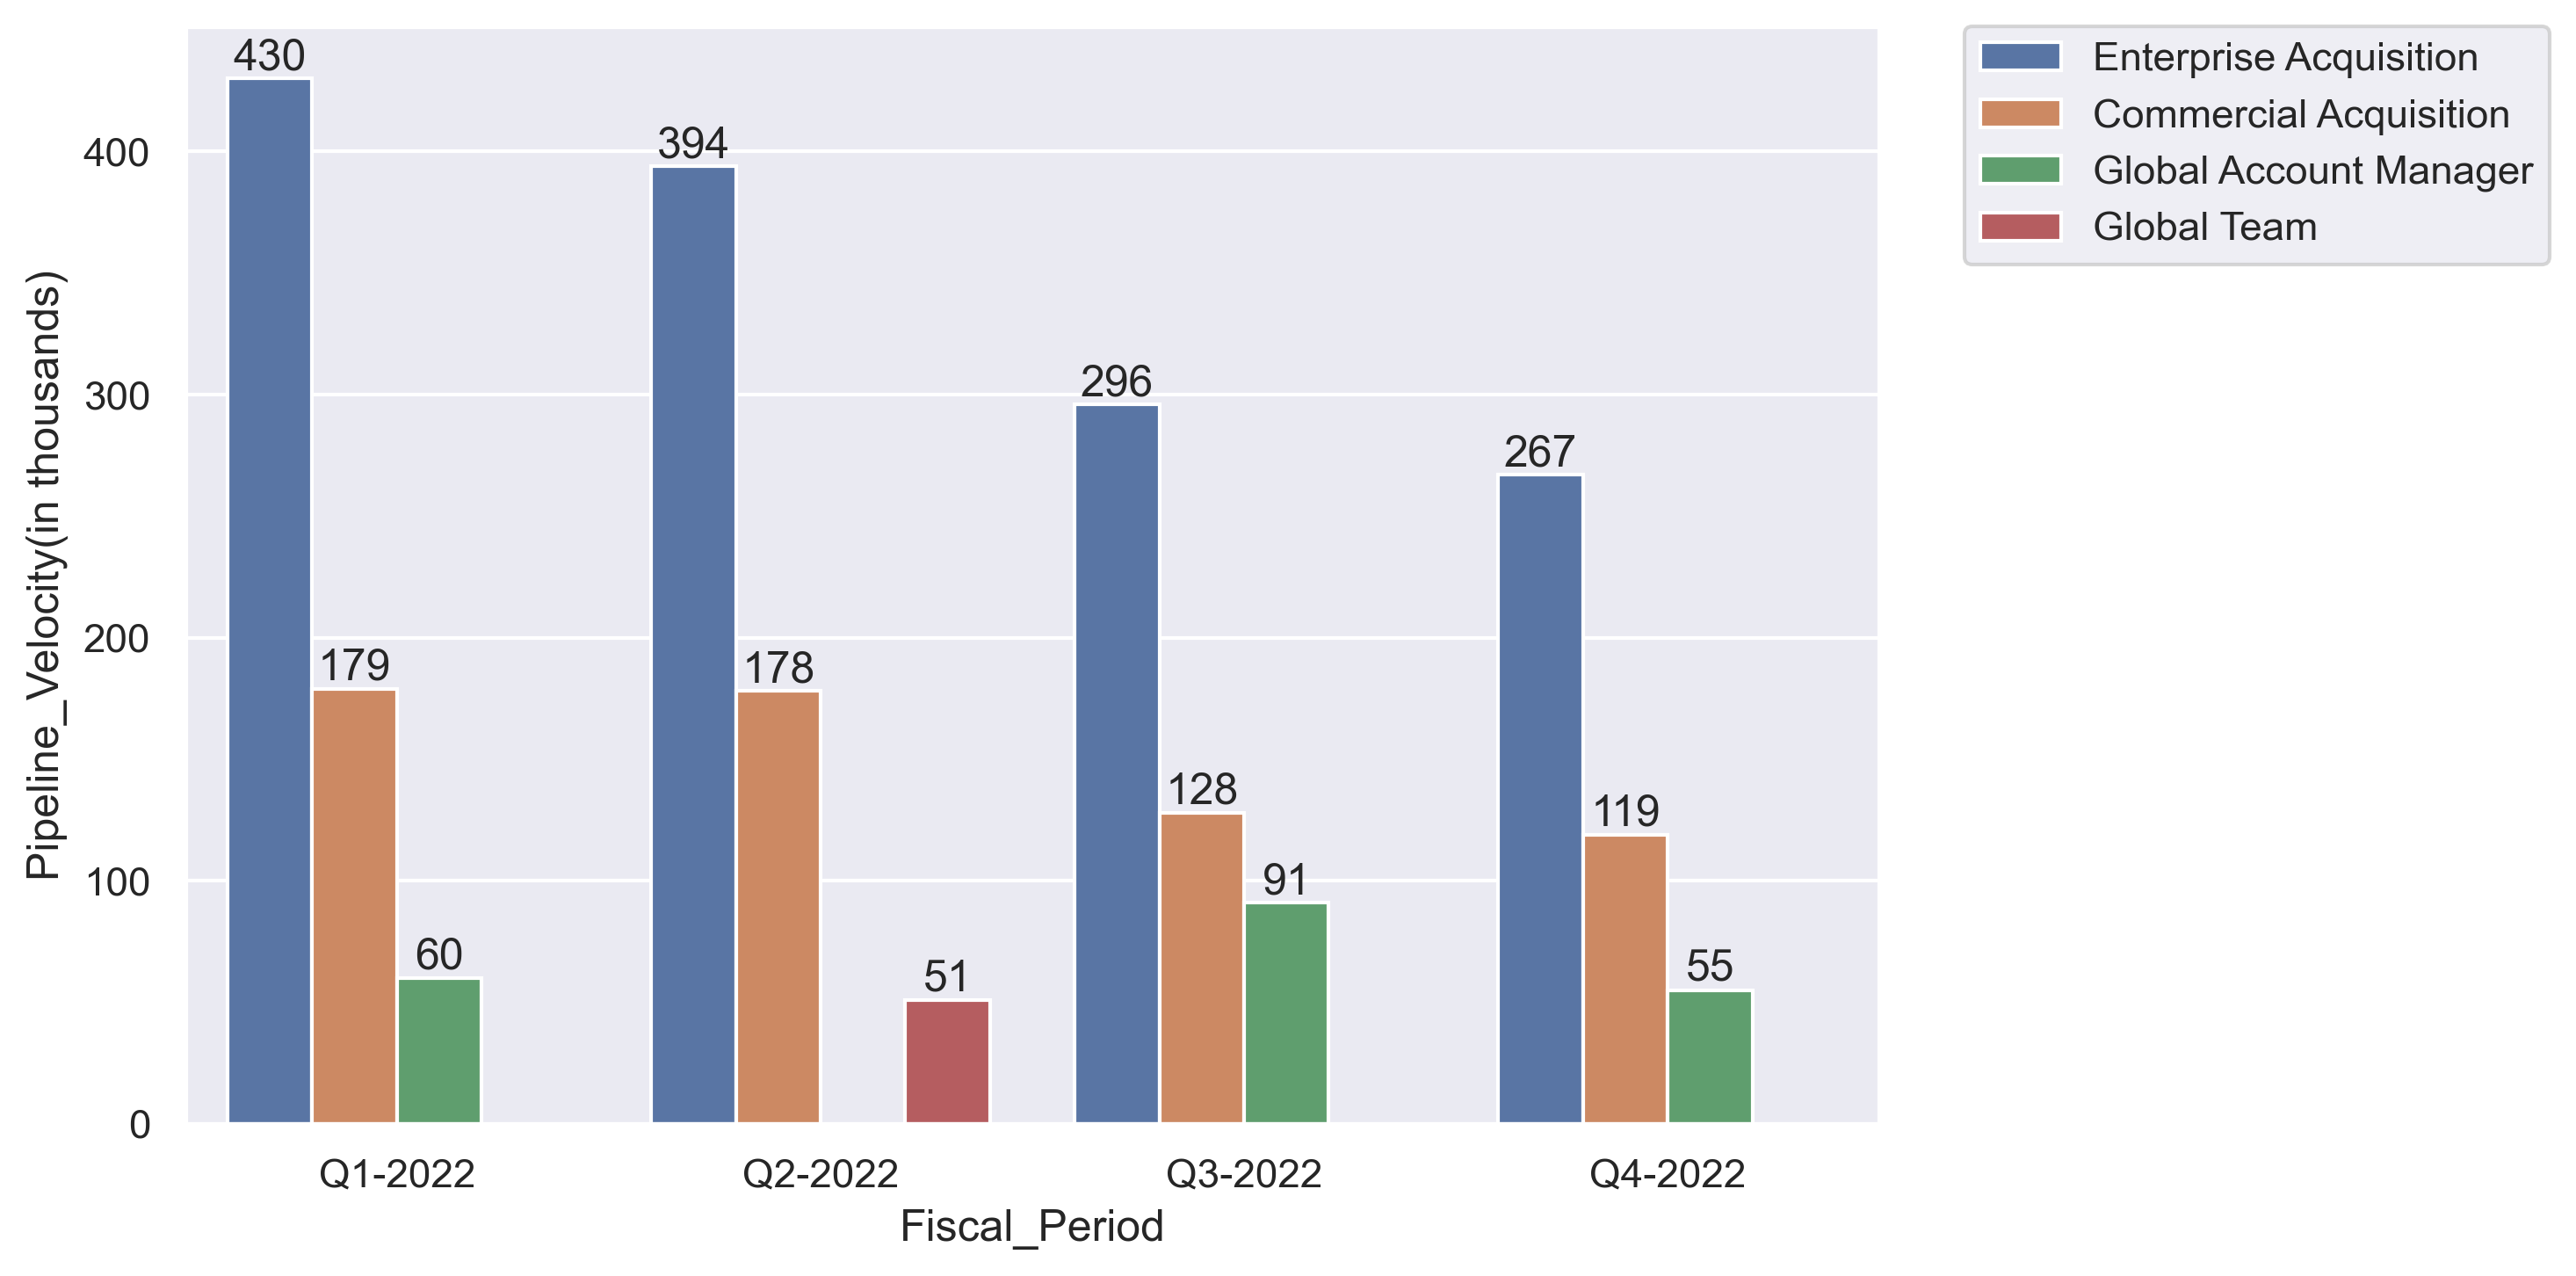

In [146]:
#Generate plot
ax = sns.barplot(x='Fiscal_Period',y='Pipeline_Velocity(in thousands)',hue="Team",data=sales_velocity_by_team)

#ax.bar_label(ax.containers[0])
for bars in ax.containers:
        ax.bar_label(bars, fmt='%.i')
        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

## Observation

Pipeline velocity's monetary value against each team is very similar to [Pipeline Velocity by Rep](#section-title) where this number can be used to assess deal propensity against quotas for the team and for forecasting.

# Pipeline Velocity by Rep

## Query

In [22]:
# Pipeline velocity by Rep

query = """
           WITH base as
           (
           select "Beneficial Owner Dept" as "Team","Beneficial Owner" as "sales_rep",
           "Lead Record Id","Stage","Fiscal Period" as "Fiscal_Period",
           strftime('%Y-%m-%d',"True Pipe Date") as "SQL_Created_Date",
           strftime('%Y-%m-%d',"Close Date") as "Opp_Close_Date",
           CAST(JULIANDAY("Close Date") - JULIANDAY("True Pipe Date") AS INTEGER) as "days_diff",
           "NC_ClosedRevenue"
           from df
           where strftime('%Y', "Close Date") = '2022' and "Beneficial Owner Dept" is not null
           and "Beneficial Owner Dept" in ("Enterprise Acquisition","Country Manager")
           and "True Pipe Date" is not null
           ),
           
           days_diff as
           (
           select "Fiscal_Period","Team","sales_rep",
           count("Lead Record Id") as "# of SQL's",
           count(case when "Stage" = "Closed Won" then "Lead Record Id" end) as "Closed_Won",
           count(case when "Stage" = "Closed Lost" then "Lead Record Id" end) as "Closed_Lost",
           IFNULL(sum(case when "Stage" ="Closed Won" then "NC_ClosedRevenue" end),0.0) as "CW_Revenue",
           IFNULL(ROUND(sum(case when "Stage" = "Closed Won" then "NC_ClosedRevenue" end)
           /count(case when "Stage" = "Closed Won" then "Opportunity ID" end),2),0.0) as "Avg_deal_size",
           CAST(IFNULL(ROUND(AVG(case when "Stage" = "Closed Won" then "days_diff" end),1),0.0) as integer) as "Lead_Speed"
           from base
           group by "Fiscal_Period","Team","sales_rep"
           ),
           
           win_rate as
           (
           select *,IFNULL((("Closed_Won" * 100) / ("Closed_Lost" + "Closed_Won")),0) as "Win_Rate",
           CASE WHEN "Fiscal_Period" like '%-2022' then 1 else 2 end
                       as "Fiscal_Period_Order"
           from days_diff
           --where "CW_Revenue" > 0.0
           ),
           
           velocity as 
           (
           select *,IFNULL(ROUND(("# of SQL's" * "Avg_deal_size" * ("Win_Rate")/100) / ("Lead_Speed"),2),0.00) 
           as "Sales_Velocity"
           from win_rate
           order by "Fiscal_Period_Order"
           ),
           
           top_3_reps as
           (
           select "Fiscal_Period","sales_rep","Sales_Velocity",
           row_number() over (partition by "Fiscal_Period" order by "Sales_Velocity" desc) as "Rank"
           from
           velocity
           )
           
           
           select "Fiscal_Period","sales_rep",
         CAST(("Sales_Velocity")/1000 AS INTEGER) as "Pipeline_Velocity ( $$ in thousands)"
         from top_3_reps
         where "Rank" <= 3
        
       """ 
sales_velocity_by_rep = sqldf(query)
sales_velocity_by_rep

,Fiscal_Period,sales_rep,Pipeline_Velocity
0,Q1-2022,Oguzhan Ozdemir,68
1,Q1-2022,Lauren Olahi,53
2,Q1-2022,Tito Mendoza,53
3,Q2-2022,Lauren Olahi,60
4,Q2-2022,Adam Surdy,32
5,Q2-2022,Ebad Jangda,32
6,Q3-2022,Nathan Chase,37
7,Q3-2022,John Babers,37
8,Q3-2022,Adam Surdy,34
9,Q4-2022,Oguzhan Ozdemir,44


## Visual Plot

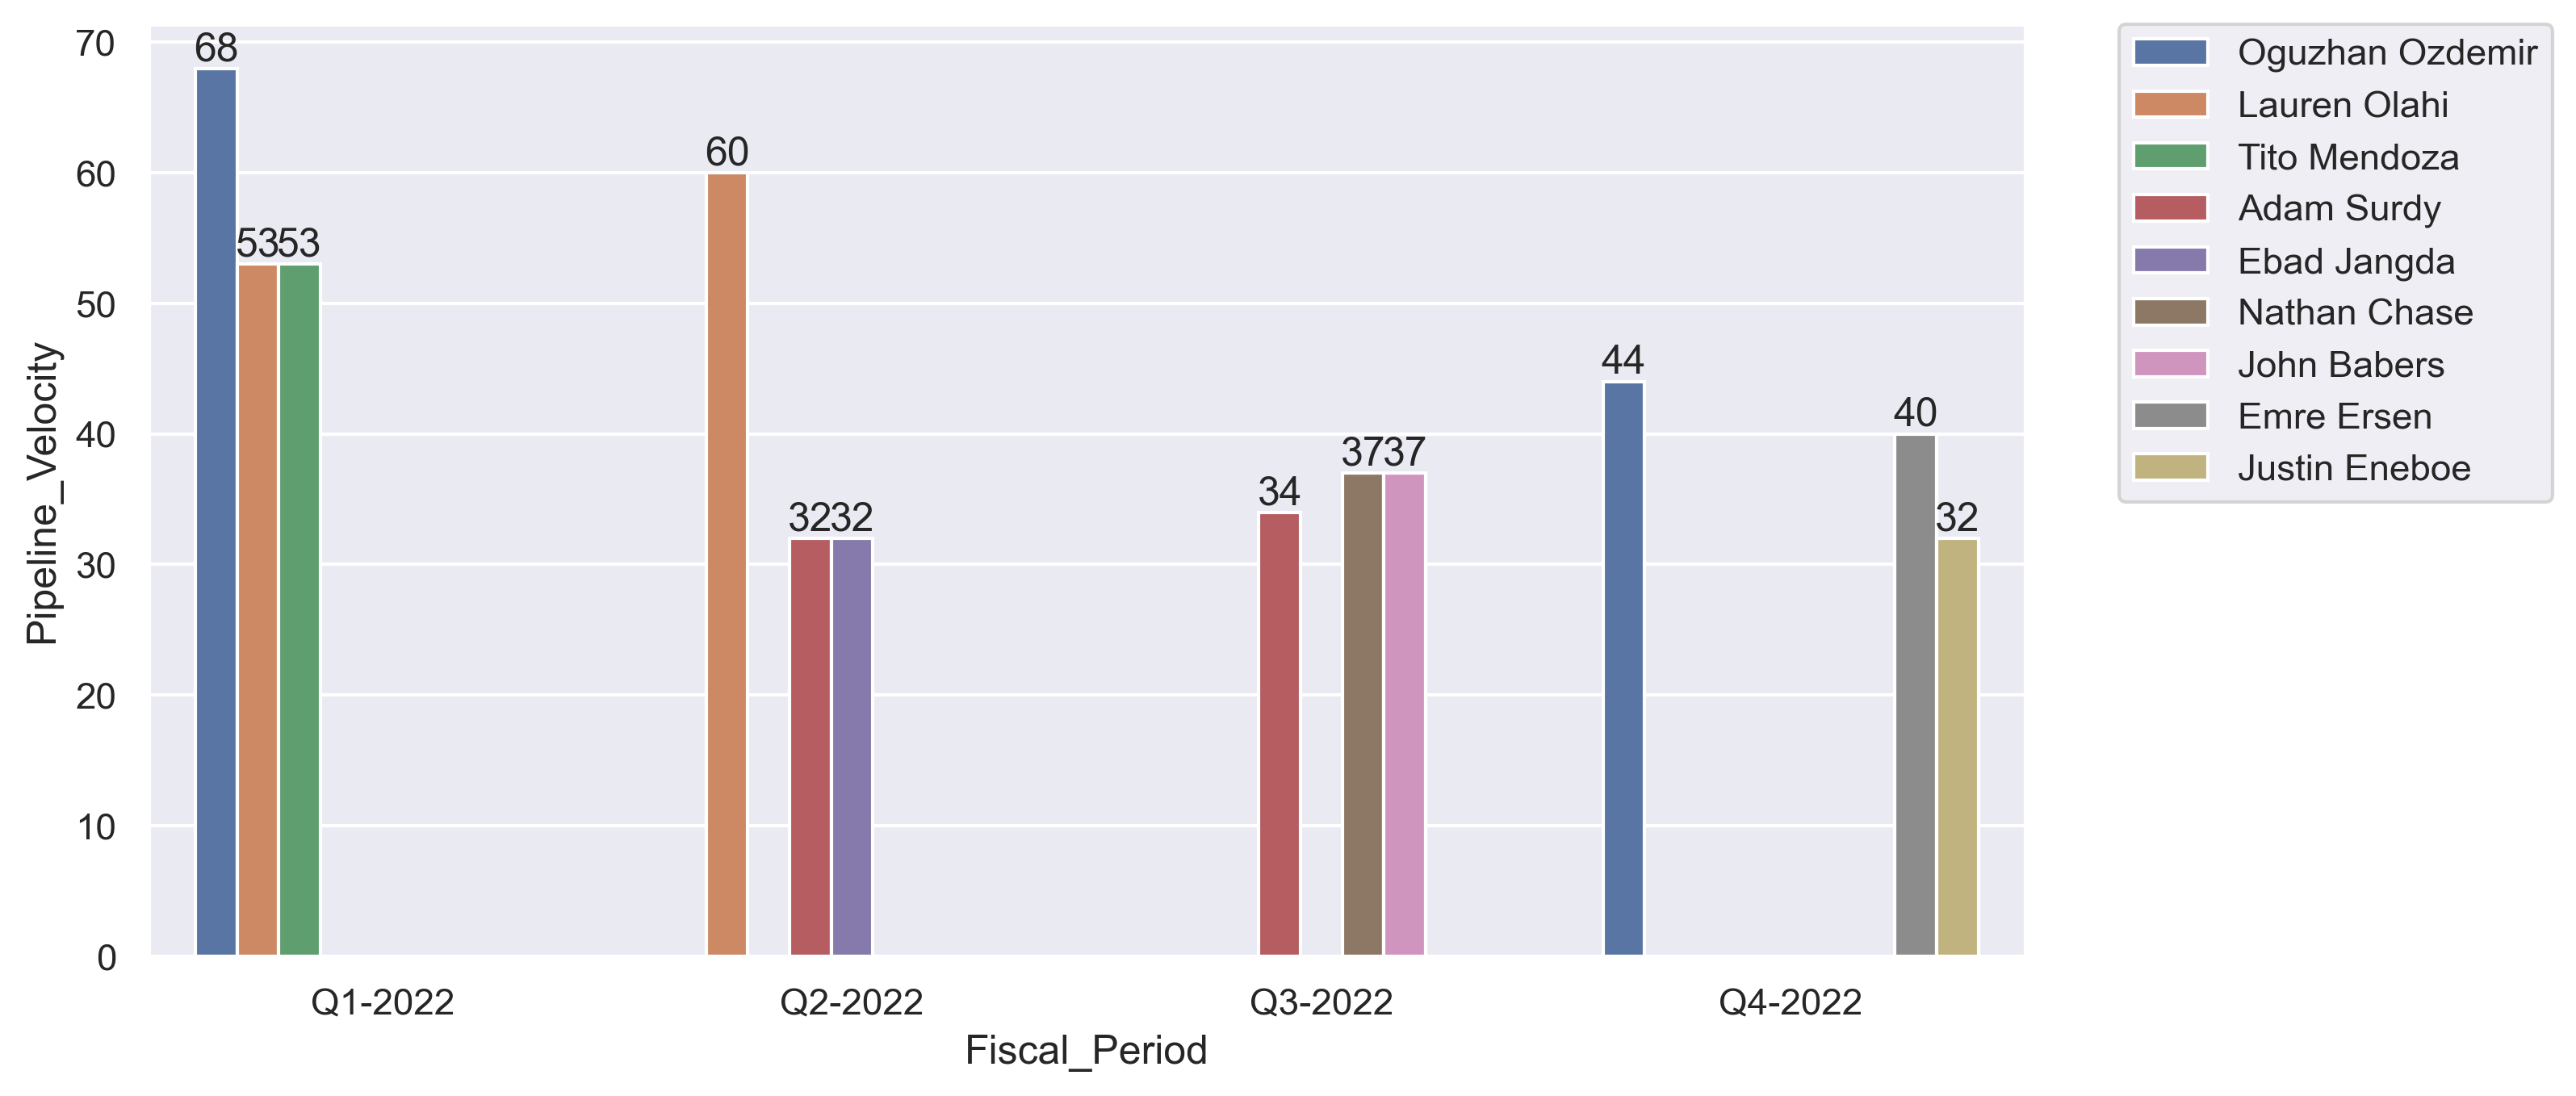

In [23]:
#Generate plot
ax = sns.barplot(x='Fiscal_Period',y='Pipeline_Velocity',hue='sales_rep',data=sales_velocity_by_rep)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.i')
        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Observation

This is a number which can be measured over a time period like Year/Quarter/Team and compare this to the Quotas set for the team for that time period. If they are on track to beat it, great else we can examine our sales activities and adjust goals, if needed. 

# Forecast Efficiency by Team

## Query

In [229]:
# Note: Removed rows where Beneficial Owner and their Department is null in the original data

query = """
           WITH forecast_vs_closed as
           (
           select strftime('%Y',"True Pipe Date") as "Year","Beneficial Owner Dept" as "Team",
           ROUND(CAST(sum("NC_ForecastedRevenue") AS INTEGER)/1000000.0,2) as "Forecasted_Revenue",
           ROUND(CAST(sum(case when "Stage" = "Closed Won" then "NC_ClosedRevenue" end) AS INTEGER)/1000000.0,2) as "Closed_Revenue"
           from df
           where strftime('%Y',"True Pipe Date") > '2020' and "Beneficial Owner Dept" is not null
           and "Lead Record Id" is not null
           group by strftime('%Y',"True Pipe Date"),"Beneficial Owner Dept"
           ),
           
           eff_pct as
           (
           select *, CAST(("Closed_Revenue"*100 / "Forecasted_Revenue") AS INTEGER) as "Forecast_Efficiency(%)"
           from forecast_vs_closed
           ),
           
           top_teams as
           (
           select *, ROW_NUMBER() over (partition by "Year" order by "Forecast_Efficiency(%)" desc) as "Rank"
           from eff_pct
           )
           
           select "Year","Team","Forecasted_Revenue","Closed_Revenue","Forecast_Efficiency(%)"
           from top_teams
           where "Rank" <= 5
           
           """ 

forecast_efficiency = sqldf(query)
forecast_efficiency

,Year,Team,Forecasted_Revenue,Closed_Revenue,Forecast_Efficiency(%)
0,2021,Commercial Expansion,5.98,3.79,63
1,2021,Country Manager,3.71,1.83,49
2,2021,Commercial Acquisition,67.15,22.37,33
3,2021,Enterprise Acquisition,487.81,163.71,33
4,2021,Global Account Manager,43.25,12.53,28
5,2022,Commercial Acquisition,69.91,23.47,33
6,2022,Commercial Expansion,5.66,1.75,30
7,2022,Country Manager,2.23,0.60,26
8,2022,Enterprise Acquisition,460.19,111.52,24
9,2022,Global Team,45.79,10.74,23


## Visual Plot

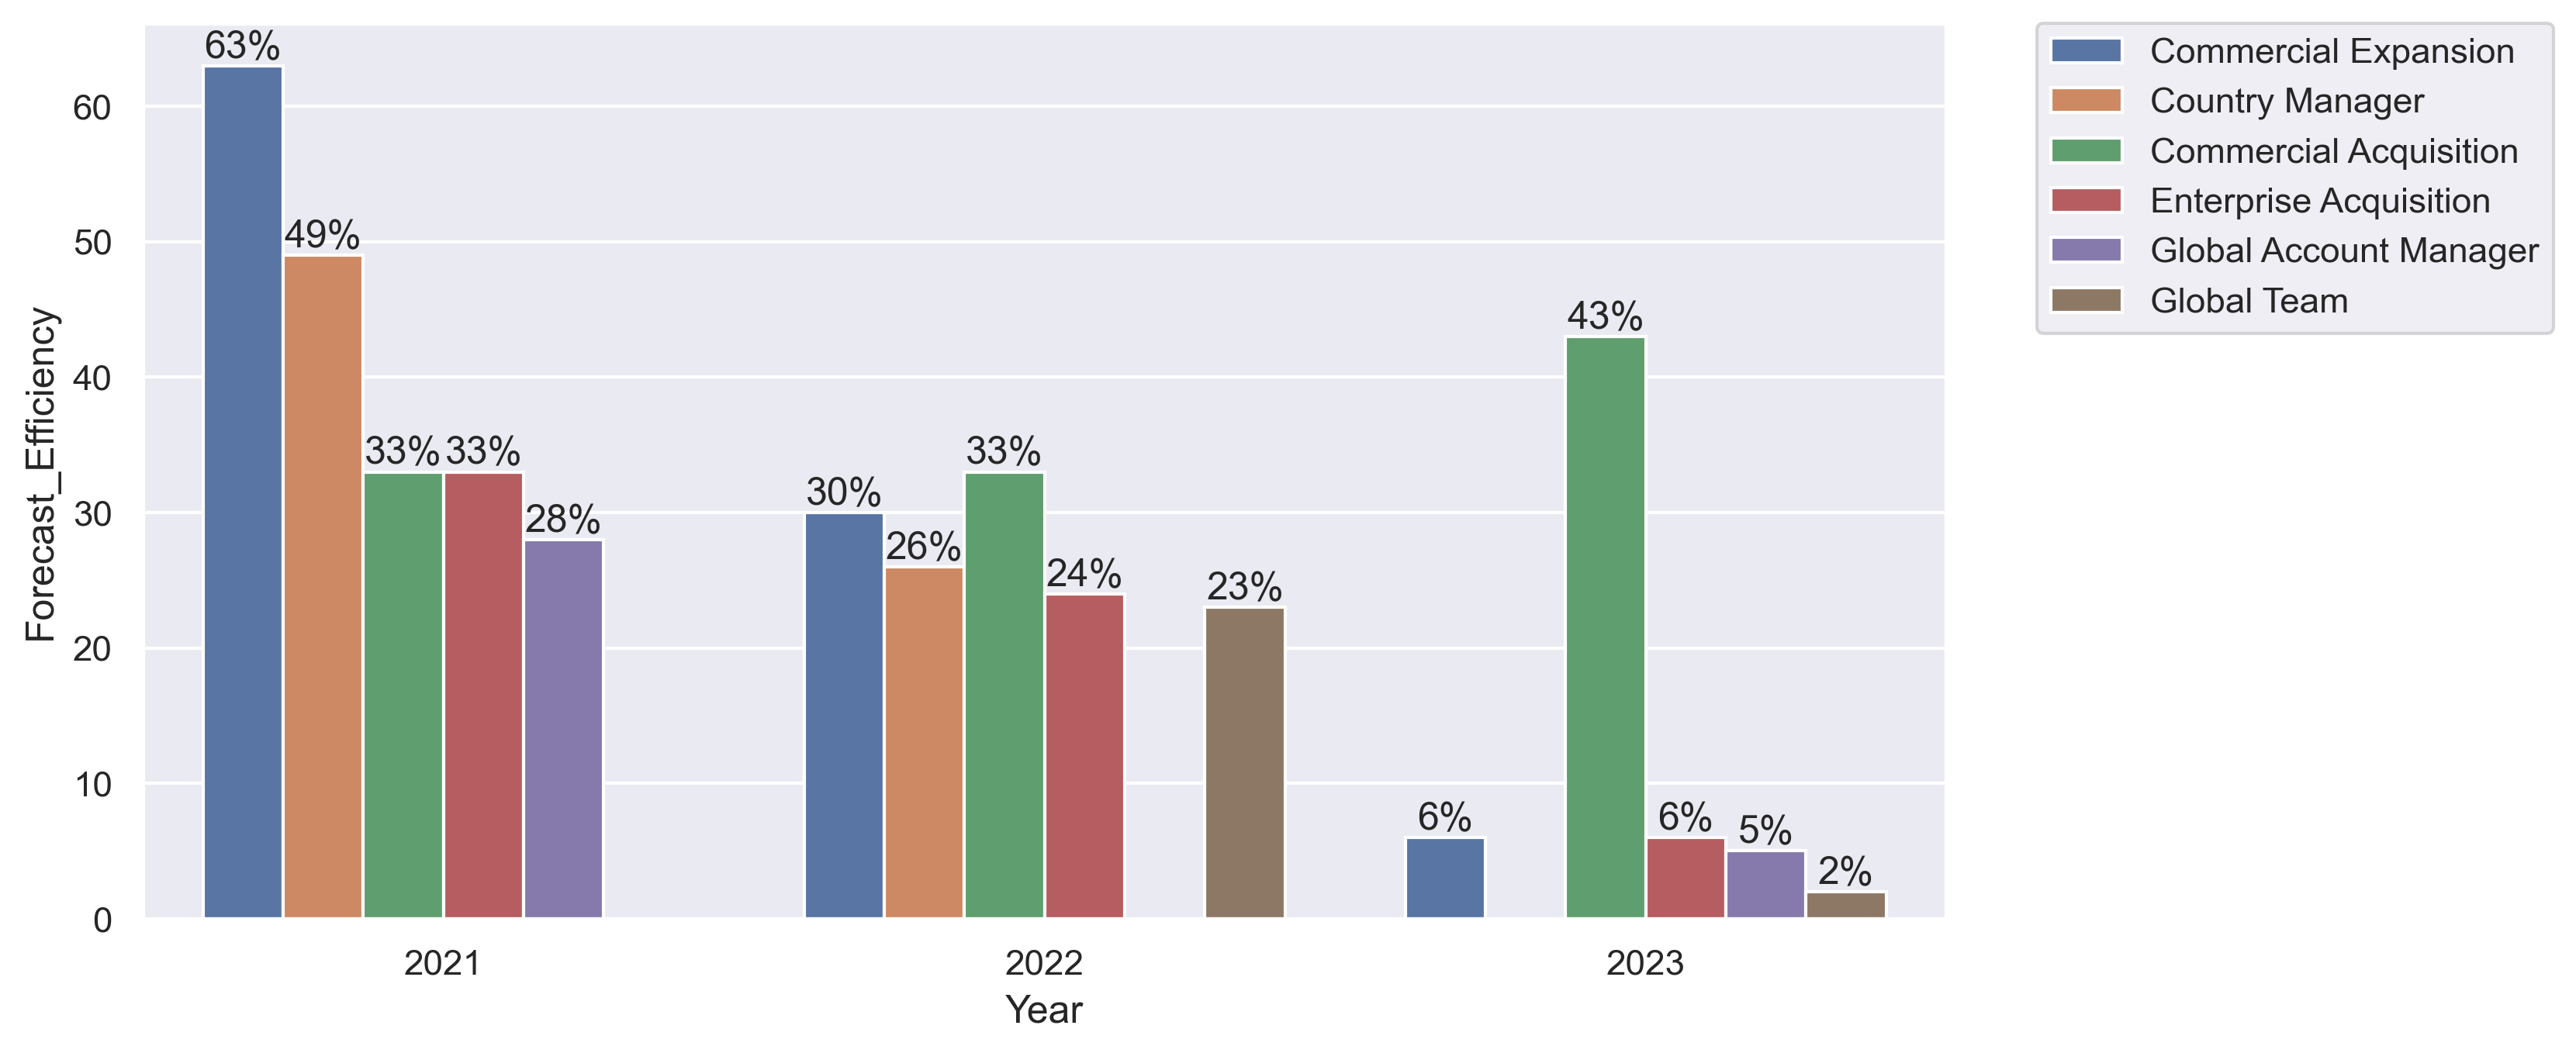

In [148]:
# Generate plot
#palette = sns.color_palette("summer",n_colors=15)
#palette.reverse()
ax = sns.barplot(x='Year',y='Forecast_Efficiency',hue="Team",data=forecast_efficiency)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%i%%')
        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Observation

This perspective is to assess and optimize, if needed, the forecasting capability of teams by observing the relationship between Revenue Forecasted Vs Revenue Achieved in 2 ways :

1. If YoY or QoQ, the gap between teams forecasting to bring in a certain amount at the start of the (year or quarter) increases, it could indicate a need to adjust either the goals or dive deeper into a) reasons for high confidence in forecasting b) lack of conversion. 

2. If there is a negative gap YoY or QoQ( min 2-3 quarters need to be considered), i.e. Teams are forecasting a certain amount and are way exceeding it "consistently", then it indicates that teams could be attempting to game the system. This applies to reps as well. 